In [12]:
import numpy as np
import pandas as pd
import os
from PIL import Image
import matplotlib.pyplot as plt
import librosa

In [13]:
from google.colab import drive
drive.mount('/content/drive') 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
def create_dataset(folder_path): 

  images = []
  names = []
  max_length = 0
  for file in os.listdir(folder_path):
    
    image_path = os.path.join(folder_path, file)
    size = Image.open(image_path).size
    image = np.array(Image.open(image_path).resize((128,128)))
    image = image.astype('float32')
    image = np.delete(image, [3], axis=2)
    #Normalization
    image /= 255.0
    images.append(image)
    names.append(file[:-4])
    if image.shape[1]>max_length:
      max_length = image.shape[1]

  for i in range(len(images)):
    images[i] = librosa.util.fix_length(images[i], max_length, axis=1)

  images = np.array(images)

  df = pd.read_csv('/content/drive/MyDrive/Deneme/clotho_metadata_development.csv')

  keywords = []
  for i in names:
    keywords.append(df.keywords[df.file_name == i].to_list()[0].lower().split(';'))

  return names,images,keywords

In [15]:
names, images, keywords = create_dataset("/content/drive/MyDrive/Train Images")

In [16]:
all_words = []
for i in keywords:
  for j in i:
    if len(j)>2:
      all_words.append(j)

len(all_words)

21309

In [17]:
from collections import Counter

frequency_list = Counter(all_words).most_common(300)

In [18]:
keywords_updated = []
for j in range(len(keywords)):
  keyword_list = []
  for i in frequency_list:
    if i[0] in keywords[j]:
      keyword_list.append(i[0])
  keywords_updated.append(keyword_list)

In [19]:
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
multihot = mlb.fit_transform(keywords_updated)
class_labels = list(mlb.classes_)

In [20]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(images, multihot, test_size=0.15, random_state=33)
print(X_train.shape,X_test.shape)

(2459, 128, 128, 3) (434, 128, 128, 3)


In [21]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

## LEARNING RATE AND MOMENTUM'S EFFECT IN MODEL

In [22]:
#reference: https://www.kaggle.com/christianlillelund/classify-mnist-audio-using-spectrograms-keras-cnn


model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Input(shape=(128,128, 3)))
model.add(tf.keras.layers.Conv2D(32, 3, strides=2, padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(300, activation='softmax'))

# Compile model

accuracy_list = []
momentum_list = []
lr_list = []
for i in range(4):
  list_2 = []
  for j in range(1,5):
    model.compile(
        loss='categorical_crossentropy',
        optimizer=SGD(learning_rate = 0.0002*j , momentum = i/10),
        metrics=['accuracy'],
        )

    fit = model.fit(X_train, y_train, epochs=10, verbose = 0)
    _, acc = model.evaluate(X_test, y_test, verbose = 1)   
    lr_list.append(0.0002*j)
    list_2.append(acc)
  momentum_list.append(i/10)
  accuracy_list.append(list_2)
  f = open("accuracies.txt", "a")
  f.write("momentum: " + str(i/10) + "lr: " + str(0.0002*j))
  f.write("\n" + str(accuracy_list))
  f.close()

14/14 [==============================] - 1s 89ms/step - loss: 185.4615 - accuracy: 0.0438


In [40]:
acc_list = []
for i in range(4):
  temp_1 = accuracy_list[1][i*4:(i+1)*4]
  acc_list.append(temp_1)

[]

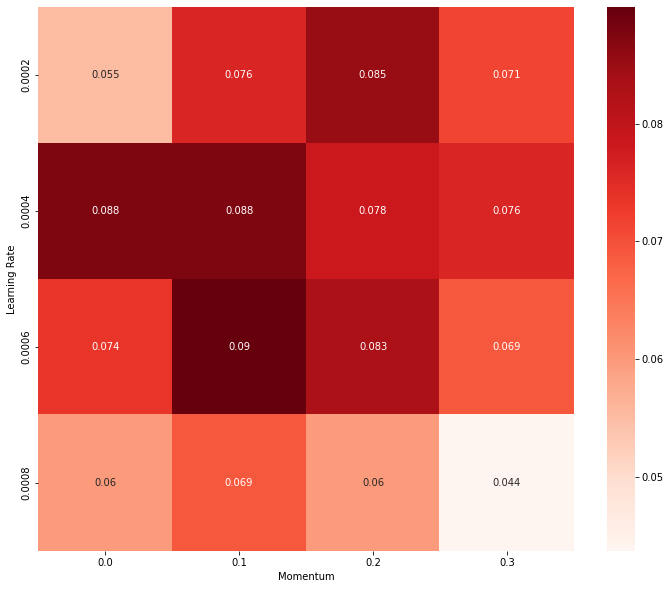

In [54]:
import seaborn as sns

y_axis_labels = lr_list[:4]
x_axis_labels = momentum_list[:4]
fig, ax = plt.subplots(figsize=(12,10))   
ax = sns.heatmap(acc_list, cbar=True, annot=True, cmap = 'Reds', xticklabels=x_axis_labels, yticklabels=y_axis_labels)
ax.set(ylabel='Learning Rate', xlabel='Momentum')
ax.plot()